In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
# df = pd.read_csv('s3://olistdashdb/csv/olist_customers_dataset.csv')

GETTING THE DATA

In [11]:
from olistdash.data import Olist
data = Olist().get_data()

In [12]:
orders = data['orders'].copy()

In [13]:
orders = orders.query("order_status=='delivered'").copy()

In [17]:
orders = orders.query("order_status=='delivered'").reset_index()
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders = orders[(orders['order_purchase_timestamp'] >= '2017-01-01') & (orders['order_purchase_timestamp'] <= '2018-07-31' )]
orders['delay_vs_expected'] = (orders['order_estimated_delivery_date'] - orders['order_delivered_customer_date']) / np.timedelta64(24, 'h')
orders['wait_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']) / np.timedelta64(24, 'h')
def handle_delay(x):
    if x < 0:
        return abs(x)
    else:
        return 0
    
orders.loc[:,'delay_vs_expected'] = orders['delay_vs_expected'].apply(handle_delay)

In [26]:
orders['delay_vs_expected'].mean()

0.8087269915726026

In [25]:
orders[orders['delay_vs_expected'] == orders['delay_vs_expected'].max()]

level_0  index                          order_id  \
50036    53966  55619  1b3190b2dfa9d789e1f14c05b647a14a   

                            customer_id order_status order_purchase_timestamp  \
50036  d306426abe5fca15e54b645e4462dc7b    delivered      2018-02-23 14:57:35   

         order_approved_at order_delivered_carrier_date  \
50036  2018-02-23 15:16:14          2018-02-26 18:49:07   

      order_delivered_customer_date order_estimated_delivery_date  \
50036           2018-09-19 23:24:07                    2018-03-15   

       delay_vs_expected   wait_time  
50036         188.975081  208.351759

TOTAL PAYMENTS TO OLIST

In [15]:
data['order_payments']['payment_value'].sum()

16008872.12

In [45]:
df = data['order_payments'][['order_id','payment_value']].merge(data['orders'][['order_id','order_purchase_timestamp']], on='order_id', how='outer')

In [46]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df = df.set_index('order_purchase_timestamp').sort_index()
df

order_id  payment_value
order_purchase_timestamp                                                 
2016-09-04 21:15:19       2e7a8482f6fb09756ca50c10d7bfc047         136.23
2016-09-05 00:15:34       e5fa5a7210941f7d56d0208e4e071d35          75.06
2016-09-13 15:24:19       809a282bbd5dbcabb6f2f724fca862ec          40.95
2016-09-15 12:16:38       bfbd0f9bdef84302105ad712db648a6c            NaN
2016-10-02 22:07:52       71303d7e93b399f5bcd537d124c0bcfa         109.34
...                                                    ...            ...
2018-09-29 09:13:03       392ed9afd714e3c74767d0c4d3e3f477         137.03
2018-10-01 15:30:09       616fa7d4871b87832197b2a137a115d2          80.38
2018-10-03 18:55:29       a2ac6dad85cf8af5b0afb510a240fe8c         197.55
2018-10-16 20:16:02       b059ee4de278302d550a3035c4cdb740         222.03
2018-10-17 17:30:18       10a045cdf6a5650c21e9cfeb60384c16          89.71

[103887 rows x 2 columns]

order_purchase_timestamp
2016-12-31      59362.34
2017-12-31    7249746.73
2018-12-31    8699763.05
Freq: A-DEC, Name: payment_value, dtype: float64


Text(0.5, 1.0, 'Yearly payment value')

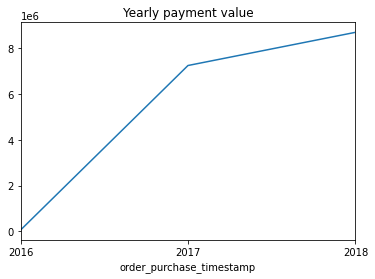

In [13]:
print(df.resample('Y')['payment_value'].sum())
df.resample('Y')['payment_value'].sum().plot()
plt.title('Yearly payment value')

order_purchase_timestamp
2016-09-30        252.24
2016-10-31      59090.48
2016-11-30          0.00
2016-12-31         19.62
2017-01-31     138488.04
2017-02-28     291908.01
2017-03-31     449863.60
2017-04-30     417788.03
2017-05-31     592918.82
2017-06-30     511276.38
2017-07-31     592382.92
2017-08-31     674396.32
2017-09-30     727762.45
2017-10-31     779677.88
2017-11-30    1194882.80
2017-12-31     878401.48
2018-01-31    1115004.18
2018-02-28     992463.34
2018-03-31    1159652.12
2018-04-30    1160785.48
2018-05-31    1153982.15
2018-06-30    1023880.50
2018-07-31    1066540.75
2018-08-31    1022425.32
2018-09-30       4439.54
2018-10-31        589.67
Freq: M, Name: payment_value, dtype: float64


Text(0.5, 1.0, 'Monthly payment value')

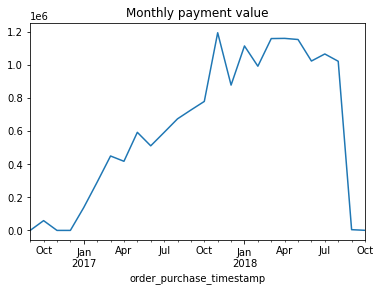

In [15]:
print(df.resample('M')['payment_value'].sum())
df.resample('M')['payment_value'].sum().plot()
plt.title('Monthly payment value')

In [20]:
df_month = pd.DataFrame(df.resample('M')['payment_value'].sum()).reset_index()
df_month.head()

order_purchase_timestamp  payment_value
0               2016-09-30         252.24
1               2016-10-31       59090.48
2               2016-11-30           0.00
3               2016-12-31          19.62
4               2017-01-31      138488.04

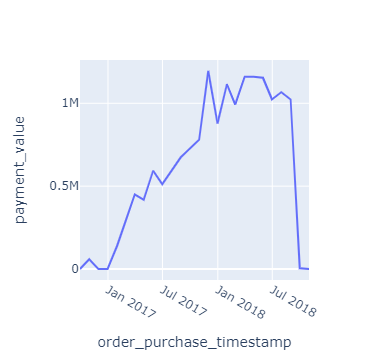

In [21]:
fig = px.line(df_month,x='order_purchase_timestamp',y='payment_value')
fig.show()

In [92]:
df['month'] = pd.to_datetime(df['order_purchase_timestamp']).dt.month

In [93]:
df.groupby('year')['payment_value'].sum()

year
2016      59362.34
2017    7249746.73
2018    8699763.05
Name: payment_value, dtype: float64

In [94]:
df.head()

order_id  payment_value order_purchase_timestamp  \
0  b81ef226f3fe1789b1e8b2acac839d17          99.33      2018-04-25 22:01:49   
1  a9810da82917af2d9aefd1278f1dcfa0          24.39      2018-06-26 11:01:38   
2  25e8ea4e93396b6fa0d3dd708e76c1bd          65.71      2017-12-12 11:19:55   
3  ba78997921bbcdc1373bb41e913ab953         107.78      2017-12-06 12:04:06   
4  42fdf880ba16b47b59251dd489d4441a         128.45      2018-05-21 13:59:17   

         date  year  month  
0  2018-04-25  2018      4  
1  2018-06-26  2018      6  
2  2017-12-12  2017     12  
3  2017-12-06  2017     12  
4  2018-05-21  2018      5

In [95]:
df = df.sort_values(by=['date'])

In [49]:
y = df.groupby('date')['payment_value'].sum().reset_index(drop=True)
y

0      136.23
1       75.06
2       40.95
3        0.00
4      109.34
        ...  
629    137.03
630     80.38
631    197.55
632    222.03
633     89.71
Name: payment_value, Length: 634, dtype: float64

In [50]:
x = df['date'].drop_duplicates()
x

29482     2016-09-04
63668     2016-09-05
61038     2016-09-13
103886    2016-09-15
35342     2016-10-02
             ...    
95876     2018-09-29
38098     2018-10-01
66093     2018-10-03
5958      2018-10-16
11904     2018-10-17
Name: date, Length: 634, dtype: object

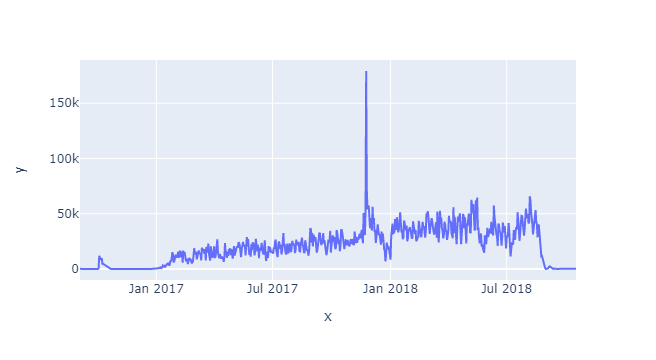

In [73]:
df_1 = pd.concat([x, y], axis=1)

# df = px.data.stocks()
# fig = px.line(df, x='date', y="GOOG")
# fig.show()

fig = px.line(df_1,x,y)
# fig.update_traces(xperiod="M1")
fig.show()

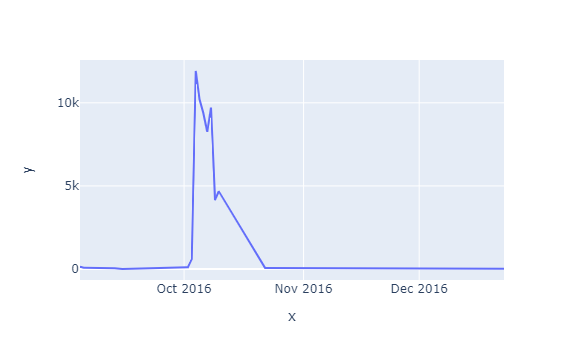

In [102]:
def year_2016():
    df_2016 = df[df['year'] == 2016]
    y = df_2016.groupby('date')['payment_value'].sum().reset_index(drop=True)
    x = df_2016['date'].drop_duplicates()
    df_plot = pd.concat([x, y], axis=1)
    fig = px.line(df_plot,x,y)
    return fig.show()

year_2016()

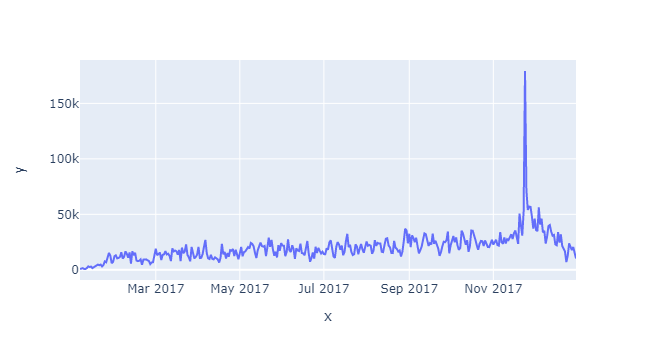

In [111]:
def year_2017():
    df_2017 = df[df['year'] == 2017]
    y = df_2017.groupby('date')['payment_value'].sum().reset_index(drop=True)
    x = df_2017['date'].drop_duplicates()
    df_plot = pd.concat([x, y], axis=1)
    fig = px.line(df_plot,x,y)
#     fig.update_traces(xperiod="M0.5")
    return fig.show()

year_2017()

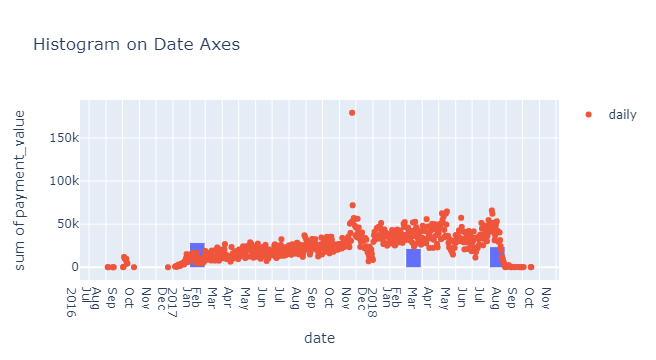

In [98]:
# fig = px.histogram(df_1, x="date", y="payment_value", histfunc="sum", title="Histogram on Date Axes")
# fig.update_traces(xbins_size="M")
# fig.update_xaxes(showgrid=True, ticklabelmode="period", dtick="M1", tickformat="%b\n%Y")
# fig.update_layout(bargap=0.1)
# fig.add_trace(go.Scatter(mode="markers", x=x, y=y, name="daily"))
# fig.show()

In [4]:
df_graph = pd.read_csv('../data/df_graph.csv')
df_graph.head()

Date  Calibre Index Fund "Nasdaq Composite, x"  \
0  2007-12-31          135.149994            2018-02-07   
1  2008-01-02          133.220001            2018-02-08   
2  2008-01-03          133.220001            2018-02-09   
3  2008-01-04          129.949997            2018-02-12   
4  2008-01-07          130.369995            2018-02-13   

   "Nasdaq Composite, y" "MSCI EAFE Index Fund (ETF), x"  \
0            7051.979980                      2008-01-02   
1            6777.160156                      2008-01-03   
2            6874.490234                      2008-01-04   
3            6981.959961                      2008-01-07   
4            7013.509766                      2008-01-08   

   MSCI EAFE Index Fund (ETF)  "Dow Jones Industrial Average, y"  \
0                       78.22                       13264.820313   
1                       78.35                       13043.959961   
2                       76.57                       13056.719727   
3                       76.65                       12800.179688   
4                       76.22                       12827.490234   

   "S&amp;P 500 Index, y"  
0             1468.359985  
1             1447.160034  
2             1447.160034  
3             1411.630005  
4             1416.180054

In [50]:
type(df_graph['Date'])

pandas.core.series.Series

In [6]:
fig = go.Figure(
    [
        go.Scatter(
            x=df_graph["Date"],
            y=df_graph["Calibre Index Fund"],
            line=dict(color = "#DE3562"),
            name="Calibre Index Fund",
        )
    ]
)
fig.add_trace(
    go.Scatter(
        x=df_graph["Date"],
        y=df_graph["MSCI EAFE Index Fund (ETF)"],
        line={"color": "#35CDDE"},
        name="MSCI EAFE Index Fund (ETF)"
    )
)
fig.update_layout(
    autosize=True,
#                 width=700,
#                 height=200,
#                 font=dict(
#                     family="Lato, Sans-Serif",
#                     size= 10
#                     ),
                margin={
                    "r": 30,
                    "t": 30,
                    "b": 30,
                    "l": 30,
                },
                showlegend=True,
#                 titlefont=dict(
#                     family="Lato, Sans-Serif",
#                     size= 10
#                     ),
                xaxis={
                    "autorange": True,
                    "range": [
                        "2007-12-31",
                        "2018-03-06",
                    ],
                    "rangeselector": {
                        "buttons": [
                            {
                                "count": 1,
                                "label": "1Y",
                                "step": "year",
                                "stepmode": "backward",
                            },
                            {
                                "count": 3,
                                "label": "3Y",
                                "step": "year",
                                "stepmode": "backward",
                            },
                            {
                                "count": 5,
                                "label": "5Y",
                                "step": "year",
                            },
                            {
                                "count": 10,
                                "label": "10Y",
                                "step": "year",
                                "stepmode": "backward",
                            },
                            {
                                "label": "All",
                                "step": "all",
                            },
                        ]
                    },
                    "showline": True,
                    "type": "date",
                    "zeroline": False,
                },
                yaxis={
                    "autorange": True,
                    "range": [
                        18.6880162434,
                        278.431996757,
                    ],
                    "showline": True,
                    "type": "linear",
                    "zeroline": False,
                },
            )
fig.show()

NameError: name 'df_graph' is not defined

In [18]:
df_daily = pd.DataFrame(df.resample('D')['payment_value'].sum()).reset_index()
df_daily.head()

order_purchase_timestamp  payment_value
0               2016-09-04         136.23
1               2016-09-05          75.06
2               2016-09-06           0.00
3               2016-09-07           0.00
4               2016-09-08           0.00

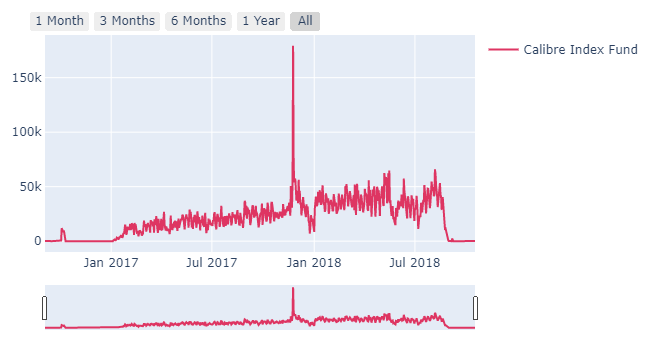

In [19]:
fig = go.Figure(
    [
        go.Scatter(
            x=df_daily["order_purchase_timestamp"],
            y=df_daily["payment_value"],
            line=dict(color = "#DE3562"),
            name="Calibre Index Fund",
        )
    ]
)
# fig.add_trace(
#     go.Scatter(
#         x=df_dayly["Date"],
#         y=df_dayly["MSCI EAFE Index Fund (ETF)"],
#         line={"color": "#35CDDE"},
#         name="MSCI EAFE Index Fund (ETF)"
#     )
# )
fig.update_layout(
    autosize=True,
#                 width=700,
#                 height=200,
#                 font=dict(
#                     family="Lato, Sans-Serif",
#                     size= 10
#                     ),
    showlegend = True,
    hovermode  = 'x',
    margin={
        "r": 30,
        "t": 30,
        "b": 30,
        "l": 30,
    },
#                 titlefont=dict(
#                     family="Lato, Sans-Serif",
#                     size= 10
#                     ),
    xaxis={
        "autorange": True,
#                     "range": [
#                         "2007-12-31",
#                         "2018-08-31",
#                     ],
        "rangeselector": {
            "buttons": [
                {
                    "count": 1,
                    "label": "1 Month",
                    "step": "month",
                    "stepmode": "backward",
                },
                {
                    "count": 3,
                    "label": "3 Months",
                    "step": "month",
                    "stepmode": "backward",
                },
                {
                    "count": 6,
                    "label": "6 Months",
                    "step": "month",
                    "stepmode": "backward",
                },
                {
                    "count": 1,
                    "label": "1 Year",
                    "step": "year",
                    "stepmode": "backward",
                },
                {
                    "label": "All",
                    "step": "all",
                },
            ]
        },
        'rangeslider':{'visible': True},
        "showline": True,
        "type": "date",
        "zeroline": False,
    },
    yaxis={
        "autorange": True,
        "range": [
            18.6880162434,
            278.431996757,
        ],
        "showline": True,
        "type": "linear",
        "zeroline": False,
    },
)
fig.show()

In [20]:
df_daily

order_purchase_timestamp  payment_value
0                 2016-09-04         136.23
1                 2016-09-05          75.06
2                 2016-09-06           0.00
3                 2016-09-07           0.00
4                 2016-09-08           0.00
..                       ...            ...
769               2018-10-13           0.00
770               2018-10-14           0.00
771               2018-10-15           0.00
772               2018-10-16         222.03
773               2018-10-17          89.71

[774 rows x 2 columns]

In [25]:
df_daily_2 = df_daily[df_daily['order_purchase_timestamp'] <= '2018-07-31']
df_daily_2

order_purchase_timestamp  payment_value
0                 2016-09-04         136.23
1                 2016-09-05          75.06
2                 2016-09-06           0.00
3                 2016-09-07           0.00
4                 2016-09-08           0.00
..                       ...            ...
691               2018-07-27       33331.12
692               2018-07-28       30168.17
693               2018-07-29       36468.26
694               2018-07-30       46288.01
695               2018-07-31       54652.10

[696 rows x 2 columns]

In [26]:
from olistdash.seller import Seller
seller = Seller()
sellers = seller.get_training_data()
sellers.head()

seller_id        seller_city seller_state  \
0  3442f8959a84dea7ee197c632cb2df15           campinas           SP   
1  d1b65fc7debc3361ea86b5f14c68d2e2         mogi guacu           SP   
2  ce3ad9de960102d0677a81f5d0bb7b2d     rio de janeiro           RJ   
3  c0f3eea2e14555b6faeea3dd58c1b1c3          sao paulo           SP   
4  51a04a8a6bdcb23deccc82b0b80742cf  braganca paulista           SP   

   delay_to_carrier  wait_time     date_first_sale      date_last_sale  \
0          1.514329  13.018588 2017-05-05 16:25:11 2017-08-30 12:50:19   
1          0.155190   9.065716 2017-03-29 02:10:34 2018-06-06 20:15:21   
2          0.000000   4.042292 2018-07-30 12:44:49 2018-07-30 12:44:49   
3          0.000000   5.667187 2018-08-03 00:44:08 2018-08-03 00:44:08   
4          3.353727  35.314861 2017-11-14 12:15:25 2017-11-14 12:15:25   

   share_of_one_stars  share_of_five_stars  review_score  n_orders  quantity  \
0            0.333333             0.333333          3.00         3         3   
1            0.050000             0.725000          4.55        40        41   
2            0.000000             1.000000          5.00         1         1   
3            0.000000             1.000000          5.00         1         1   
4            1.000000             0.000000          1.00         1         1   

   quantity_per_order     sales  
0               1.000    218.70  
1               1.025  11703.07  
2               1.000    158.00  
3               1.000     79.99  
4               1.000    167.99

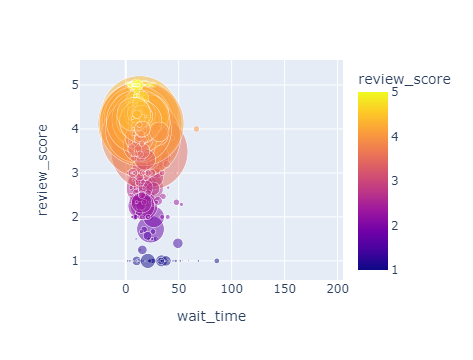

In [32]:
fig = px.scatter(data_frame=sellers,
                 x="wait_time",
                 y="review_score",
                 size="sales",
                 color="review_score",
                 size_max=60,
                 opacity=0.5)
fig.show()

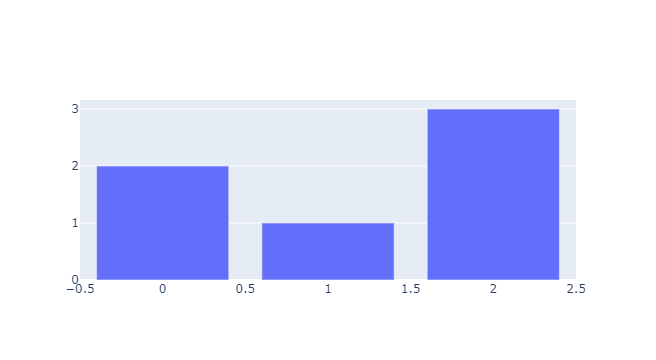

In [5]:
import plotly.graph_objects as go
fig = go.Figure(
    data=[go.Bar(y=[2, 1, 3])],
)
fig.show()

In [13]:
df = data['order_reviews']['review_score'].value_counts().reset_index().sort_values(by='index',ascending=False)
df

index  review_score
0      5         57420
1      4         19200
3      3          8287
4      2          3235
2      1         11858

In [15]:
data['order_reviews']['review_score'].value_counts().reset_index().sort_values(by='index',axis=0,ascending=False)

index  review_score
0      5         57420
1      4         19200
3      3          8287
4      2          3235
2      1         11858

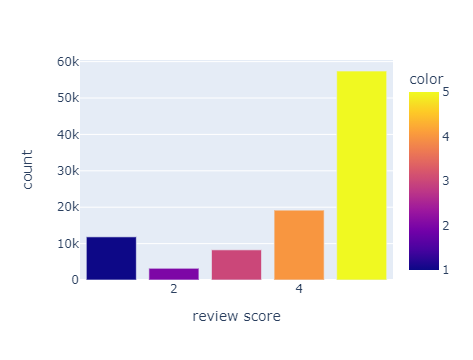

In [37]:
fig = px.bar(
    data['order_reviews']['review_score'].value_counts().reset_index(),
    y=df['review_score'],
    x=df['index'],
    color=df['index'],
    labels=dict(x='review score',y='count')
)
fig.update_layout(showlegend=False)
fig.show()

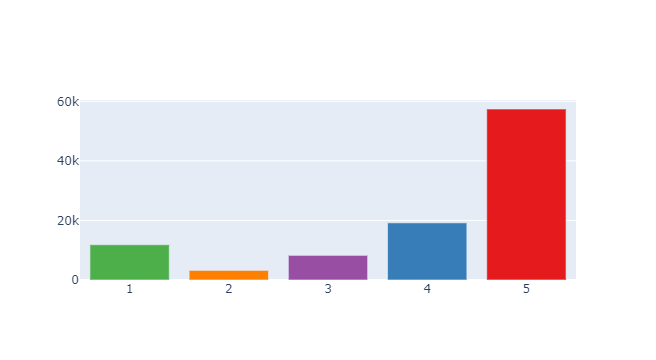

In [64]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=data['order_reviews']['review_score'].value_counts().reset_index()['index'],
        y=data['order_reviews']['review_score'].value_counts().reset_index()['review_score'],
        marker_color=['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)', 'rgb(152,78,163)', 'rgb(255,127,0)']
    )
)

fig.show()


In [41]:
data['order_reviews']['review_score'].value_counts()

5    57420
4    19200
1    11858
3     8287
2     3235
Name: review_score, dtype: int64

In [63]:
print(px.colors.qualitative.Set1)

['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)', 'rgb(152,78,163)', 'rgb(255,127,0)', 'rgb(255,255,51)', 'rgb(166,86,40)', 'rgb(247,129,191)', 'rgb(153,153,153)']


In [6]:
data['order_reviews'][['review_score']]

review_score
0                 4
1                 5
2                 5
3                 5
4                 5
...             ...
99995             5
99996             5
99997             4
99998             1
99999             1

[100000 rows x 1 columns]

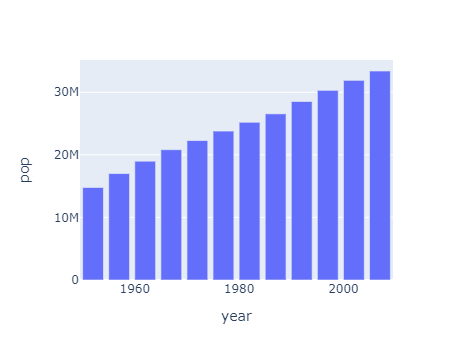

In [17]:
import plotly.express as px
data_canada = px.data.gapminder().query("country == 'Canada'")
fig = px.bar(data_canada, x='year', y='pop')
fig.show()

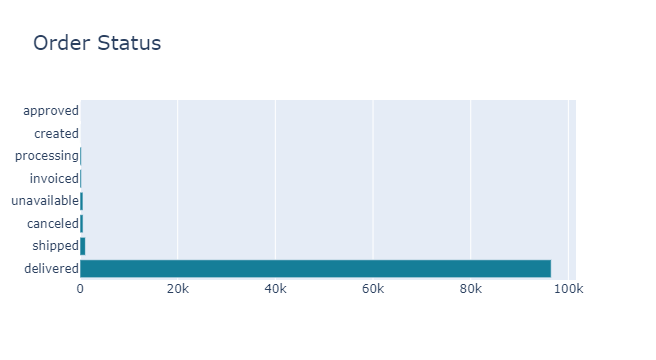

In [65]:
fig = go.Figure()
fig.add_trace(
        go.Bar(
            y=data['orders']['order_status'].value_counts().reset_index()['index'],
            x=data['orders']['order_status'].value_counts().reset_index()['order_status'],
            marker_color='#157E98',
            orientation='h'
        )
    )
fig.update_layout(title_text="Order Status",
                  title_font_size=20)
fig.show()

In [66]:
import dash
import dash_table

In [67]:
data['orders']['order_status'].value_counts().reset_index()

index  order_status
0    delivered         96478
1      shipped          1107
2     canceled           625
3  unavailable           609
4     invoiced           314
5   processing           301
6      created             5
7     approved             2

In [71]:
df = data['orders']['order_status'].value_counts().reset_index()

dash_table.DataTable(
    id='table',
    columns=[{"name": i, "id": i} for i in df.columns],
    data=df.to_dict('records'),
)

DataTable(id='table', columns=[{'name': 'index', 'id': 'index'}, {'name': 'order_status', 'id': 'order_status'}], data=[{'index': 'delivered', 'order_status': 96478}, {'index': 'shipped', 'order_status': 1107}, {'index': 'canceled', 'order_status': 625}, {'index': 'unavailable', 'order_status': 609}, {'index': 'invoiced', 'order_status': 314}, {'index': 'processing', 'order_status': 301}, {'index': 'created', 'order_status': 5}, {'index': 'approved', 'order_status': 2}])

In [5]:
def table_order_status():
    return data['orders']['order_status'].value_counts().reset_index()

table_order_status().columns

Index(['index', 'order_status'], dtype='object')

In [6]:
columns=[{"name": i, "id": i} for i in table_order_status().columns],

In [7]:
columns

([{'name': 'index', 'id': 'index'},
  {'name': 'order_status', 'id': 'order_status'}],)

---

In [27]:
reviews = data['order_reviews'].copy()

In [28]:
reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'])
reviews.set_index('review_creation_date', inplace=True)

In [34]:
reviewsReview.resample('M').agg({'review_score':'mean'})

review_score
review_creation_date              
2017-02-28                4.269663
2017-03-31                4.012774
2017-04-30                4.025641
2017-05-31                4.086456
2017-06-30                4.109290
2017-07-31                4.167610
2017-08-31                4.213104
2017-09-30                4.164939
2017-10-31                4.170112
2017-11-30                4.098466
2017-12-31                3.913087
2018-01-31                4.045833
2018-02-28                3.990921
2018-03-31                3.711778
2018-04-30                3.902993
2018-05-31                4.179071
2018-06-30                4.189502
2018-07-31                4.273497
2018-08-31                4.197278

In [41]:
reviews.resample('M').agg({'review_score':'mean'}).reset_index()['review_score']

review_creation_date  review_score
0            2016-10-31      4.033149
1            2016-11-30      3.166667
2            2016-12-31      2.270833
3            2017-01-31      4.338912
4            2017-02-28      4.269663
5            2017-03-31      4.012774
6            2017-04-30      4.025641
7            2017-05-31      4.086456
8            2017-06-30      4.109290
9            2017-07-31      4.167610
10           2017-08-31      4.213104
11           2017-09-30      4.164939
12           2017-10-31      4.170112
13           2017-11-30      4.098466
14           2017-12-31      3.913087
15           2018-01-31      4.045833
16           2018-02-28      3.990921
17           2018-03-31      3.711778
18           2018-04-30      3.902993
19           2018-05-31      4.179071
20           2018-06-30      4.189502
21           2018-07-31      4.273497
22           2018-08-31      4.197278

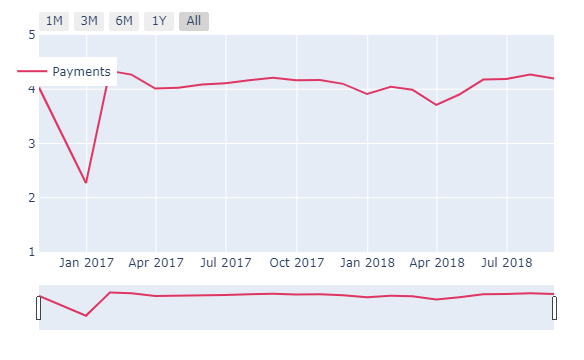

In [44]:
fig = go.Figure(
    [
        go.Scatter(
            x=reviews.resample('M').agg({'review_score':'mean'}).reset_index()['review_creation_date'],
            y=reviews.resample('M').agg({'review_score':'mean'}).reset_index()['review_score'],
            line=dict(color = "#DE3562"),
            name="Payments",
        )
    ]
)
# fig.add_trace(
#     go.Scatter(
#         x=df_dayly["Date"],
#         y=df_dayly["MSCI EAFE Index Fund (ETF)"],
#         line={"color": "#35CDDE"},
#         name="MSCI EAFE Index Fund (ETF)"
#     )
# )
fig.update_layout(
    autosize=True,
#                 width=700,
#                 height=200,
#                 font=dict(
#                     family="Lato, Sans-Serif",
#                     size= 10
#                     ),
    showlegend = True,
    hovermode  = 'x',
    margin={
        "r": 30,
        "t": 30,
        "b": 30,
        "l": 30,
    },
    legend=dict(
            yanchor="top",
            y=0.9,
            xanchor="center",
            x=0.05,
            font=dict(
                size=12,
            )
        ),
#                 titlefont=dict(
#                     family="Lato, Sans-Serif",
#                     size= 10
#                     ),
    xaxis={
        "autorange": True,
#                     "range": [
#                         "2007-12-31",
#                         "2018-08-31",
#                     ],
        "rangeselector": {
            "buttons": [
                {
                    "count": 1,
                    "label": "1M",
                    "step": "month",
                    "stepmode": "backward",
                },
                {
                    "count": 3,
                    "label": "3M",
                    "step": "month",
                    "stepmode": "backward",
                },
                {
                    "count": 6,
                    "label": "6M",
                    "step": "month",
                    "stepmode": "backward",
                },
                {
                    "count": 1,
                    "label": "1Y",
                    "step": "year",
                    "stepmode": "backward",
                },
                {
                    "label": "All",
                    "step": "all",
                },
            ]
        },
        'rangeslider':{'visible': True},
        "showline": True,
        "type": "date",
        "zeroline": False,
    },
    yaxis={
#         "autorange": True,
        "range": [
            1,
            5,
        ],
        "showline": True,
        "type": "linear",
        "zeroline": False,
    },
)
fig.show()

In [36]:
from olistdash.data import Olist
data = Olist().get_data()

In [37]:
orders = data['orders'].copy()

In [38]:
orders = orders.query("order_status=='delivered'").reset_index()

In [39]:
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

In [40]:
orders['delay_vs_expected'] = (orders['order_estimated_delivery_date'] - orders['order_delivered_customer_date']) / np.timedelta64(24, 'h')

In [42]:
orders['wait_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']) / np.timedelta64(24, 'h')

In [45]:
orders['order_delivered_customer_date']

0       2017-10-10 21:25:13
1       2018-08-07 15:27:45
2       2018-08-17 18:06:29
3       2017-12-02 00:28:42
4       2018-02-16 18:17:02
                ...        
96473   2017-03-17 15:08:01
96474   2018-02-28 17:37:56
96475   2017-09-21 11:24:17
96476   2018-01-25 23:32:54
96477   2018-03-16 13:08:30
Name: order_delivered_customer_date, Length: 96478, dtype: datetime64[ns]

In [44]:
orders['wait_time']

0         8.436574
1        13.782037
2         9.394213
3        13.208750
4         2.873877
           ...    
96473     8.218009
96474    22.193727
96475    24.859421
96476    17.086424
96477     7.674306
Name: wait_time, Length: 96478, dtype: float64

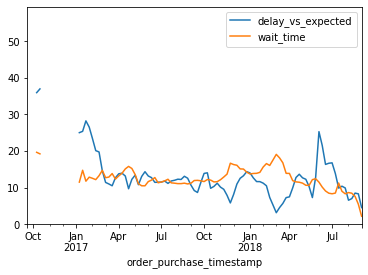

In [43]:
orders.set_index('order_purchase_timestamp').resample('W')[['delay_vs_expected', 'wait_time']].mean().plot()
plt.ylim(ymin=0);

In [34]:
orders.set_index('order_purchase_timestamp').resample('W')[['delay_vs_expected', 'wait_time']].mean().reset_index()['delay_vs_expected']

0     -36.324745
1            NaN
2            NaN
3      35.944881
4      36.967405
         ...    
98      6.573945
99      7.009272
100     8.518945
101     8.316325
102     4.561027
Name: delay_vs_expected, Length: 103, dtype: float64

In [35]:
data['orders']

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp    order_approved_at  \
0        delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
...            ...                      ...                  ...   
99436    delivered      2017-03-09 09:54:05  2017-03-09 09:54:05   
99437    delivered      2018-02-06 12:58:58  2018-02-06 13:10:37   
99438    delivered      2017-08-27 14:46:43  2017-08-27 15:04:16   
99439    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
99440    delivered      2018-03-08 20:57:30  2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99436          2017-03-10 11:18:03           2017-03-17 15:08:01   
99437          2018-02-07 23:22:42           2018-02-28 17:37:56   
99438          2017-08-28 20:52:26           2017-09-21 11:24:17   
99439          2018-01-12 15:35:03           2018-01-25 23:32:54   
99440          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  
0               2017-10-18 00:00:00  
1               2018-08-13 00:00:00  
2               2018-09-04 00:00:00  
3               2017-12-15 00:00:00  
4               2018-02-26 00:00:00  
...                             ...  
99436           2017-03-28 00:00:00  
99437           2018-03-02 00:00:00  
99438           2017-09-27 00:00:00  
99439           2018-02-15 00:00:00  
99440           2018-04-03 00:00:00  

[99441 rows x 8 columns]

In [28]:
from olistdash.order import Order
Order().get_price_and_freight()

order_id   price  freight_value
0      00010242fe8c5a6d1ba2dd792cb16214   58.90          13.29
1      00018f77f2f0320c557190d7a144bdd3  239.90          19.93
2      000229ec398224ef6ca0657da4fc703e  199.00          17.87
3      00024acbcdf0a6daa1e931b038114c75   12.99          12.79
4      00042b26cf59d7ce69dfabb4e55b4fd9  199.90          18.14
...                                 ...     ...            ...
98661  fffc94f6ce00a00581880bf54a75a037  299.99          43.41
98662  fffcd46ef2263f404302a634eb57f7eb  350.00          36.53
98663  fffce4705a9662cd70adb13d4a31832d   99.90          16.95
98664  fffe18544ffabc95dfada21779c9644f   55.99           8.72
98665  fffe41c64501cc87c801fd61db3f6244   43.00          12.79

[98666 rows x 3 columns]

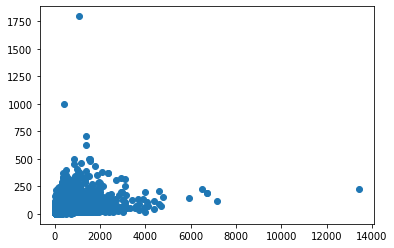

In [32]:
plt.scatter(x=Order().get_price_and_freight()['price'],y=Order().get_price_and_freight()['freight_value'])

In [49]:
from olistdash.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True) 

In [53]:
orders.corr()

wait_time  expected_wait_time  delay_vs_expected  \
wait_time                  1.000000            0.383501           0.707329   
expected_wait_time         0.383501            1.000000           0.005993   
delay_vs_expected          0.707329            0.005993           1.000000   
dim_is_five_star          -0.235280           -0.050203          -0.157359   
dim_is_one_star            0.306392            0.034950           0.283186   
review_score              -0.335082           -0.052296          -0.271966   
number_of_products        -0.019244            0.016287          -0.013241   
number_of_sellers         -0.040724            0.024778          -0.017177   
price                      0.055897            0.076189           0.017079   
freight_value              0.167041            0.239051           0.024286   
distance_seller_customer   0.393250            0.513757           0.066492   

                          dim_is_five_star  dim_is_one_star  review_score  \
wait_time                        -0.235280         0.306392     -0.335082   
expected_wait_time               -0.050203         0.034950     -0.052296   
delay_vs_expected                -0.157359         0.283186     -0.271966   
dim_is_five_star                  1.000000        -0.400339      0.792041   
dim_is_one_star                  -0.400339         1.000000     -0.810337   
review_score                      0.792041        -0.810337      1.000000   
number_of_products               -0.073181         0.120458     -0.124262   
number_of_sellers                -0.070579         0.101664     -0.116390   
price                            -0.013813         0.046013     -0.035811   
freight_value                    -0.059535         0.084189     -0.091034   
distance_seller_customer         -0.056552         0.043521     -0.059232   

                          number_of_products  number_of_sellers     price  \
wait_time                          -0.019244          -0.040724  0.055897   
expected_wait_time                  0.016287           0.024778  0.076189   
delay_vs_expected                  -0.013241          -0.017177  0.017079   
dim_is_five_star                   -0.073181          -0.070579 -0.013813   
dim_is_one_star                     0.120458           0.101664  0.046013   
review_score                       -0.124262          -0.116390 -0.035811   
number_of_products                  1.000000           0.286230  0.153992   
number_of_sellers                   0.286230           1.000000  0.042385   
price                               0.153992           0.042385  1.000000   
freight_value                       0.439729           0.133497  0.411600   
distance_seller_customer           -0.016683          -0.007524  0.079705   

                          freight_value  distance_seller_customer  
wait_time                      0.167041                  0.393250  
expected_wait_time             0.239051                  0.513757  
delay_vs_expected              0.024286                  0.066492  
dim_is_five_star              -0.059535                 -0.056552  
dim_is_one_star                0.084189                  0.043521  
review_score                  -0.091034                 -0.059232  
number_of_products             0.439729                 -0.016683  
number_of_sellers              0.133497                 -0.007524  
price                          0.411600                  0.079705  
freight_value                  1.000000                  0.313953  
distance_seller_customer       0.313953                  1.000000

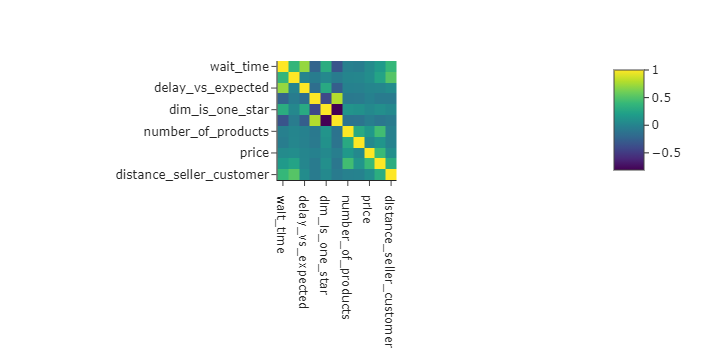

In [50]:
import plotly.express as px

# df = px.data.medals_wide(indexed=True)
fig = px.imshow(orders.corr(), template='simple_white')
fig.show()

In [39]:
df

medal        gold  silver  bronze
nation                           
South Korea    24      13      11
China          10      15       8
Canada          9      12      12

In [40]:
orders.corr()

level_0     index  delay_vs_expected  wait_time
level_0            1.000000  1.000000           0.002899   0.003321
index              1.000000  1.000000           0.002899   0.003321
delay_vs_expected  0.002899  0.002899           1.000000   0.716848
wait_time          0.003321  0.003321           0.716848   1.000000

In [54]:
import statsmodels.formula.api as smf

In [55]:
features = [
    "wait_time",
    "delay_vs_expected",
    "number_of_products",
    "number_of_sellers",
    "price",
    "freight_value",
    "distance_seller_customer",
]

In [56]:
# standardizing features
orders_standardized = orders.copy()
for f in features:
    mu = orders[f].mean()
    sigma = orders[f].std()
    orders_standardized[f] = orders[f].map(lambda x: (x - mu) / sigma)

orders_standardized

order_id  wait_time  expected_wait_time  \
0      e481f51cbdc54678b7cc49136f2d6af7  -0.431707           15.544063   
1      53cdb2fc8bc7dce0b6741e2150273451   0.128587           19.137766   
2      47770eb9100c2d0c44946d9cf07ec65d  -0.331330           26.639711   
3      949d5b44dbf5de918fe9c16f97b45f8a   0.068497           26.188819   
4      ad21c59c0840e6cb83a9ceb5573f8159  -1.014771           12.112049   
...                                 ...        ...                 ...   
96528  9c5dedf39a927c1b2549525ed64a053c  -0.454616           18.587442   
96529  63943bddc261676b46f01ca7ac2f7bd8   1.010273           23.459051   
96530  83c1379a015df1e13d02aae0204711ab   1.289682           30.384225   
96531  11c177c8e97725db2631073c19f07b62   0.474942           37.105243   
96532  66dea50a8b16d9b4dee7af250b4be1a5  -0.511605           25.126736   

       delay_vs_expected order_status  dim_is_five_star  dim_is_one_star  \
0              -0.162787    delivered                 0                0   
1              -0.162787    delivered                 0                0   
2              -0.162787    delivered                 1                0   
3              -0.162787    delivered                 1                0   
4              -0.162787    delivered                 1                0   
...                  ...          ...               ...              ...   
96528          -0.162787    delivered                 1                0   
96529          -0.162787    delivered                 0                0   
96530          -0.162787    delivered                 1                0   
96531          -0.162787    delivered                 0                0   
96532          -0.162787    delivered                 1                0   

       review_score  number_of_products  number_of_sellers     price  \
0                 4           -0.264004          -0.112813 -0.511860   
1                 4           -0.264004          -0.112813 -0.087278   
2                 5           -0.264004          -0.112813  0.109912   
3                 5           -0.264004          -0.112813 -0.440019   
4                 5           -0.264004          -0.112813 -0.560153   
...             ...                 ...                ...       ...   
96528             5           -0.264004          -0.112813 -0.310793   
96529             4           -0.264004          -0.112813  0.181705   
96530             5           -0.264004          -0.112813  0.330507   
96531             2            1.586072          -0.112813  1.067531   
96532             5           -0.264004          -0.112813 -0.327544   

       freight_value  distance_seller_customer  
0          -0.651997                 -0.979467  
1          -0.000604                  0.428808  
2          -0.164844                 -0.146045  
3           0.205392                  2.052600  
4          -0.651997                 -0.959121  
...              ...                       ...  
96528      -0.449712                 -0.893083  
96529      -0.124016                 -0.213301  
96530       1.960071                  0.616570  
96531       2.709822                 -0.387946  
96532      -0.204744                  0.051677  

[96525 rows x 13 columns]

In [57]:
# Creating and training MODEL4
formula = "review_score ~ " + ' + '.join(features)
formula

'review_score ~ wait_time + delay_vs_expected + number_of_products + number_of_sellers + price + freight_value + distance_seller_customer'

In [82]:
model4 = smf.ols(formula=formula, data=orders_standardized).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     2348.
Date:                Tue, 27 Jul 2021   Prob (F-statistic):               0.00
Time:                        17:18:18   Log-Likelihood:            -1.5446e+05
No. Observations:               96525   AIC:                         3.089e+05
Df Residuals:                   96517   BIC:                         3.090e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [108]:
results_as_html = model4.summary().tables[2].as_html()
pd.read_html(results_as_html, header=0, index_col=0)[0].reset_index()

Omnibus:  18337.394     Durbin-Watson:     2.009
0  Prob(Omnibus):      0.000  Jarque-Bera (JB):  35597.40
1           Skew:     -1.163          Prob(JB):      0.00
2       Kurtosis:      4.854          Cond. No.      3.04

In [91]:
model4.summary().tables[0].as_html()

'<table class="simpletable">\n<caption>OLS Regression Results</caption>\n<tr>\n  <th>Dep. Variable:</th>      <td>review_score</td>   <th>  R-squared:         </th>  <td>   0.146</td>  \n</tr>\n<tr>\n  <th>Model:</th>                   <td>OLS</td>       <th>  Adj. R-squared:    </th>  <td>   0.145</td>  \n</tr>\n<tr>\n  <th>Method:</th>             <td>Least Squares</td>  <th>  F-statistic:       </th>  <td>   2348.</td>  \n</tr>\n<tr>\n  <th>Date:</th>             <td>Tue, 27 Jul 2021</td> <th>  Prob (F-statistic):</th>   <td>  0.00</td>   \n</tr>\n<tr>\n  <th>Time:</th>                 <td>17:23:16</td>     <th>  Log-Likelihood:    </th> <td>-1.5446e+05</td>\n</tr>\n<tr>\n  <th>No. Observations:</th>      <td> 96525</td>      <th>  AIC:               </th>  <td>3.089e+05</td> \n</tr>\n<tr>\n  <th>Df Residuals:</th>          <td> 96517</td>      <th>  BIC:               </th>  <td>3.090e+05</td> \n</tr>\n<tr>\n  <th>Df Model:</th>              <td>     7</td>      <th>               

In [85]:
# from IPython.display import display, Markdown
# display(Markdown(rf'{model4.summary().as_latex()}'))
# # print(model4.summary().as_latex())

In [86]:
# for table in model4.summary().tables:
#     print(table.as_latex_tabular())

In [59]:
model4.params

Intercept                   4.142005
wait_time                  -0.450029
delay_vs_expected          -0.044982
number_of_products         -0.132475
number_of_sellers          -0.131830
price                      -0.004405
freight_value               0.004872
distance_seller_customer    0.098776
dtype: float64

In [61]:
model4.params[1:].sort_values()

wait_time                  -0.450029
number_of_products         -0.132475
number_of_sellers          -0.131830
delay_vs_expected          -0.044982
price                      -0.004405
freight_value               0.004872
distance_seller_customer    0.098776
dtype: float64

In [69]:
fig = px.bar(pd.DataFrame(model4.params[1:].sort_values()).reset_index(),
             x=pd.DataFrame(model4.params[1:].sort_values()).reset_index()['0'],
             y=pd.DataFrame(model4.params[1:].sort_values()).reset_index()['index']
            )
fig.show()

KeyError: '0'

In [71]:
model_df = pd.DataFrame(model4.params[1:].sort_values()).reset_index()
model_df.columns = ['features', 'correlation']
model_df

features  correlation
0                 wait_time    -0.450029
1        number_of_products    -0.132475
2         number_of_sellers    -0.131830
3         delay_vs_expected    -0.044982
4                     price    -0.004405
5             freight_value     0.004872
6  distance_seller_customer     0.098776

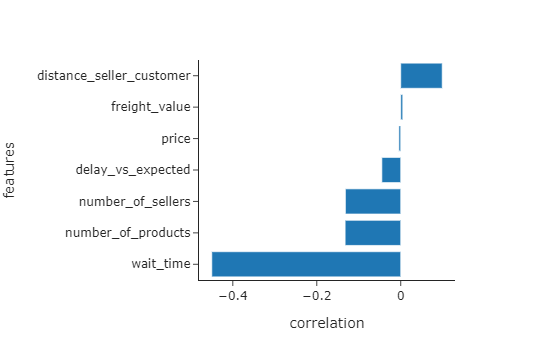

In [75]:
fig = px.bar(model_df, y='features', x='correlation',orientation='h',template='simple_white')

fig.show()

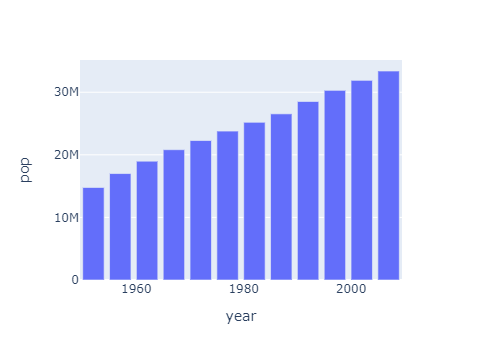

In [62]:
data_canada = px.data.gapminder().query("country == 'Canada'")
fig = px.bar(data_canada, x='year', y='pop')
fig.show()

In [63]:
data_canada

country continent  year  lifeExp       pop    gdpPercap iso_alpha  iso_num
240  Canada  Americas  1952   68.750  14785584  11367.16112       CAN      124
241  Canada  Americas  1957   69.960  17010154  12489.95006       CAN      124
242  Canada  Americas  1962   71.300  18985849  13462.48555       CAN      124
243  Canada  Americas  1967   72.130  20819767  16076.58803       CAN      124
244  Canada  Americas  1972   72.880  22284500  18970.57086       CAN      124
245  Canada  Americas  1977   74.210  23796400  22090.88306       CAN      124
246  Canada  Americas  1982   75.760  25201900  22898.79214       CAN      124
247  Canada  Americas  1987   76.860  26549700  26626.51503       CAN      124
248  Canada  Americas  1992   77.950  28523502  26342.88426       CAN      124
249  Canada  Americas  1997   78.610  30305843  28954.92589       CAN      124
250  Canada  Americas  2002   79.770  31902268  33328.96507       CAN      124
251  Canada  Americas  2007   80.653  33390141  36319.23501       CAN      124